In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [2]:
# define forum score function

def forum(actual, feature, mode='mean', nt=1000, baseline=None, presorted=False):

    # Calculate the baseline
    n = len(actual)
    if n == len(feature):
        n -= 1
    if mode == 'median': # Bootstrap the median cumulative sum with random samples
        randoms = []
        for _ in range(nt):
            randoms.append(random.sample(feature, n))
        baseline = np.array(randoms).median(axis=1)
    elif mode == 'mean': # Calculate the mean cumulative sum
        baseline = np.array([x*np.mean(feature) for x in range(1, n+1)])
    elif mode == 'precomputed': # Use a precomputed baseline
        baseline = baseline[:n]
    else:
        raise ValueError('Invalid mode')

    # Sort the feature values, if needed
    if presorted:
        s_feat = feature
    else:       
        s_feat = np.sort(feature)

    # Calculate the cumulative sums
    cs_best = np.cumsum(s_feat[::-1])[:n]
    cs_worst = np.cumsum(s_feat)[:n]
    cs_actual = np.cumsum(actual)[:n]

    # Calculate the differences from baseline
    d_best = cs_best - baseline
    d_worst = baseline - cs_worst
    d_actual = cs_actual - baseline

    # Calculate and average the ratios, +ve/-ve
    rat = np.where(d_actual>0, np.nan_to_num(d_actual/d_best), np.nan_to_num(d_actual/d_worst))

    return rat.mean()

In [3]:
# create some data

random.seed(100)

n1 = 10
size = 100
mm = 100
# rlist = [0]*(size-n1) + [1]*n1
alpha = 1
beta = 1
rlist = list(np.random.beta(alpha, beta, size))
sorted_rlist = sorted(rlist, reverse=True)
baseline = np.array([x*np.mean(sorted_rlist) for x in range(1, mm+1)])
cs_best = np.cumsum(sorted_rlist)[:mm]
cs_worst = np.cumsum(sorted_rlist[::-1])[:mm]
d_best = cs_best - baseline
d_worst = baseline - cs_worst

# shuffle half of the values in sorted_rlist
a1 = sorted_rlist.copy()
a1[::2] = random.sample(a1[::2], len(a1)//2)
a2 = random.sample(sorted_rlist, len(sorted_rlist))
a3 = sorted_rlist[::-1]
a3[1::3] = random.sample(a3[1::3], len(a3)//3)

actual_dict = {1: a1, 2: a2, 3: a3}
shuffsize=10
for k, v in actual_dict.items(): 
    actual_dict[k] = sum([random.sample(v[n:n+shuffsize], shuffsize)
                          for n in range(0, len(v), shuffsize)], [])
    actual_dict[k] = (v[:shuffsize//2] +
                      sum([random.sample(v[n+shuffsize//2:n+3*shuffsize//2], shuffsize)
                          for n in range(0, len(v)-shuffsize, shuffsize)], []) +
                        v[-shuffsize//2:])

cs_dict = {}
rat_dict = {}
for i in range(1,4):
    actual = actual_dict[i].copy()

    # Calculate the cumulative sums
    cs_actual = np.cumsum(actual)
    # Calculate the differences from baseline
    d_actual = cs_actual - baseline
    # Calculate and average the ratios, +ve/-ve
    rat = np.where(d_actual>0, np.nan_to_num(d_actual/d_best),
                   np.nan_to_num(d_actual/d_worst))[:-1]
    cs_dict[i] = cs_actual
    rat_dict[i] = rat

x = np.linspace(1, mm, size)
y = sum(rlist)*x/size


/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_12473/3550814225.py:46: RuntimeWarning: divide by zero encountered in divide
  rat = np.where(d_actual>0, np.nan_to_num(d_actual/d_best),


<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_12473/70528397.py:16: SyntaxWarning: invalid escape sequence '\D'
  ax.text(n+0.2, (cs_best[n-1] + curve[n-1])/2 + 1, '$\Delta^{br}_i$', va='center', c='g')
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_12473/70528397.py:17: SyntaxWarning: invalid escape sequence '\D'
  ax.text(n+0.2+1, (curve[n-1] + baseline[n-1])/2 + 1, '$\Delta^{pr}_i$', va='center', c=sns.color_palette()[0])
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_12473/70528397.py:18: SyntaxWarning: invalid escape sequence '\D'
  ax.text(n+0

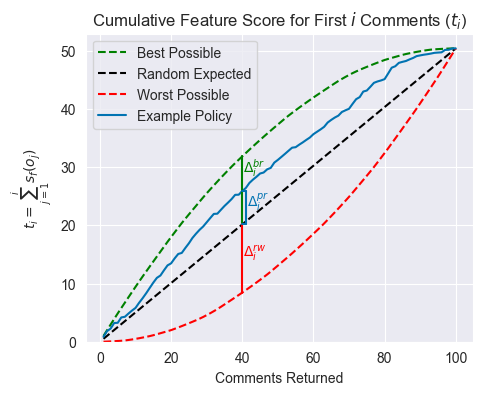

In [4]:
# plot delta calculation figure

curve = cs_dict[1]

fig, ax = plt.subplots(1, 1, figsize=(5,4))

# plot the data
ax.plot(range(1, mm+1), cs_best, ls='--', label='Best Possible', c='g')
ax.plot(x, y, c='k', ls='--', label='Random Expected')
ax.plot(range(1, mm+1), cs_worst, ls='--', label='Worst Possible', c='r')
ax.plot(range(1, mm+1), curve, label=f'Example Policy')

n = 40

# add delta text
ax.text(n+0.2, (cs_best[n-1] + curve[n-1])/2 + 1, '$\Delta^{br}_i$', va='center', c='g')
ax.text(n+0.2+1, (curve[n-1] + baseline[n-1])/2 + 1, '$\Delta^{pr}_i$', va='center', c=sns.color_palette()[0])
ax.text(n+0.2, (cs_worst[n-1] + baseline[n-1])/2 + 1, '$\Delta^{rw}_i$', va='center', c='r')

# add delta lines
ax.plot([n+1, n+1],  [baseline[n-1], curve[n-1]], c = sns.color_palette()[0])
ax.plot([n, n],  [baseline[n-1], cs_best[n-1]], c = 'g')
ax.plot([n, n],  [baseline[n-1], cs_worst[n-1]], c = 'r')
ax.plot([n, n+1],  [curve[n-1], curve[n-1]], c = sns.color_palette()[0])
ax.plot([n, n+1],  [baseline[n-1], baseline[n-1]], c = sns.color_palette()[0])

ax.set_title('Cumulative Feature Score for First $i$ Comments ($t_i$)')
ax.set_ylabel('$t_i = \sum_{j=1}^{i} s_f(o_j)$')
ax.set_xlabel('Comments Returned')
ax.set_ylim(0, max(50, sum(rlist)*1.05))
ax.legend()
plt.savefig('figs/feature_score.pdf')
plt.savefig('figs/feature_score.svg')
plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\G'
<>:41: SyntaxWarning: invalid escape sequence '\P'
<>:26: SyntaxWarning: invalid escape sequence '\G'
<>:41: SyntaxWarning: invalid escape sequence '\P'
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_12473/2787363583.py:26: SyntaxWarning: invalid escape sequence '\G'
  ax.set_ylabel('$\Gamma^p_i$')
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_12473/2787363583.py:41: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel('$\Phi_n^p$')


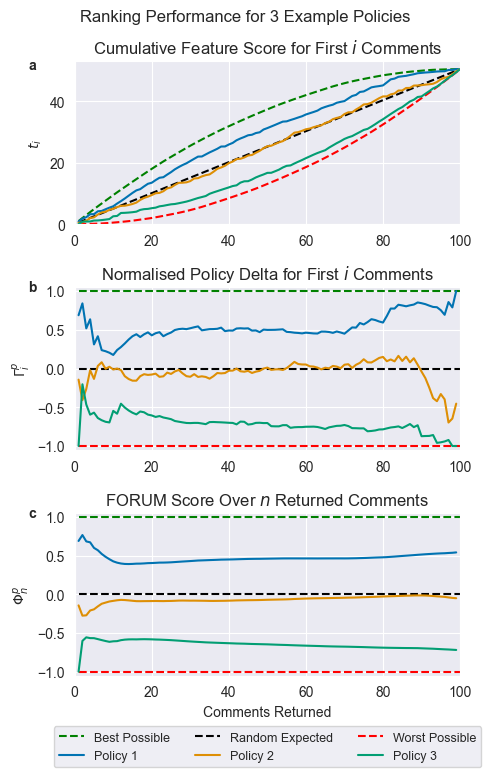

In [5]:
# Plot 3 part calculation figure

fig, axs = plt.subplots(3, 1, figsize=(5, 8))

# plot a
ax = axs[0]
ax.plot(range(1, mm+1), cs_best, ls='--', label='Best Possible', c='g')
ax.plot(x, y, c='k', ls='--', label='Random Expected')
ax.plot(range(1, mm+1), cs_worst, ls='--', label='Worst Possible', c='r')
for i in range(1,4):
    ax.plot(range(1, mm+1), cs_dict[i], label=f'Policy {i}')
ax.set_title('Cumulative Feature Score for First $i$ Comments')
ax.set_ylabel('$t_i$')
ax.set_xlim(0, mm)
ax.set_ylim(0, max(50, sum(rlist)*1.05))
ax.text(-12, sum(rlist), 'a', weight="bold")

# plot b
ax = axs[1]
ax.set_title('Normalised Policy Delta for First $i$ Comments')
ax.plot(x, [1]*size, c='g', ls='--', label='Best Possible')
ax.plot(x, [0]*size, c='k', ls='--', label='Random Expected')
ax.plot(x, [-1]*size, c='r', ls='--', label='Worst Possible')
for i in range(1,4):
    ax.plot(range(1, mm), rat_dict[i], label=f'Policy {i}')
ax.set_ylabel('$\Gamma^p_i$')
ax.set_xlim(0, mm)
ax.set_ylim(-1.05, 1.05)
ax.text(-12, 1, 'b', weight="bold")

#plot c
ax = axs[2]
ax.set_title('FORUM Score Over $n$ Returned Comments')
ax.plot(x, [1]*size, c='g', ls='--', label='Best Possible')
ax.plot(x, [0]*size, c='k', ls='--', label='Random Expected')
ax.plot(x, [-1]*size, c='r', ls='--', label='Worst Possible')
for i in range(1,4):
    ax.plot(range(1, mm), np.cumsum(rat_dict[i])/np.arange(1, mm),
            label=f'Policy {i}')
ax.set_xlabel('Comments Returned')
ax.set_ylabel('$\Phi_n^p$')
ax.set_xlim(0, mm)
ax.set_ylim(-1.05, 1.05)
ax.text(-12, 1, 'c', weight="bold")

# Get the lines and labels from the axes
lines, labels = ax.get_legend_handles_labels()

# Reorder them as desired. This is just an example, replace with your desired order.
order = [0, 3, 1, 4, 2, 5]  # replace with your desired order
lines = [lines[i] for i in order]
labels = [labels[i] for i in order]

# Create a new legend with the reordered lines and labels
ax.legend(lines, labels, ncols=3, loc='lower center',
          bbox_to_anchor=(0.5, -0.6), fontsize=9)

fig.suptitle('Ranking Performance for 3 Example Policies')
fig.tight_layout()
plt.savefig('figs/sorting_performance.pdf')
plt.savefig('figs/sorting_performance.svg')
plt.show()

<>:62: SyntaxWarning: invalid escape sequence '\G'
<>:76: SyntaxWarning: invalid escape sequence '\P'
<>:115: SyntaxWarning: invalid escape sequence '\G'
<>:131: SyntaxWarning: invalid escape sequence '\P'
<>:62: SyntaxWarning: invalid escape sequence '\G'
<>:76: SyntaxWarning: invalid escape sequence '\P'
<>:115: SyntaxWarning: invalid escape sequence '\G'
<>:131: SyntaxWarning: invalid escape sequence '\P'
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_94037/3023266627.py:62: SyntaxWarning: invalid escape sequence '\G'
  ax.set_ylabel('$\Gamma^p_i$')
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_94037/3023266627.py:76: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel('$\Phi_n^p$')
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_94037/3023266627.py:115: SyntaxWarning: invalid escape sequence '\G'
  ax.set_ylabel('$\Gamma^p_i$')
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_94037/3023266627.py:131: SyntaxWarning: invalid escap

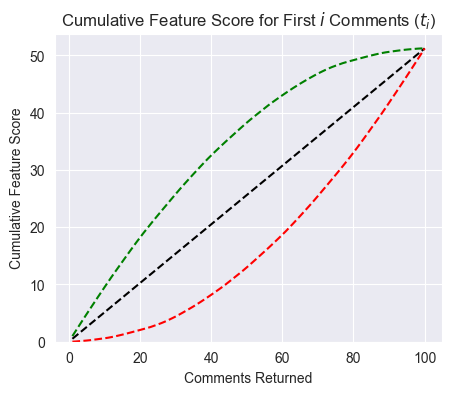

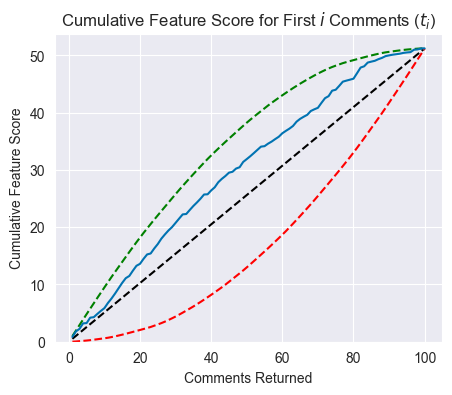

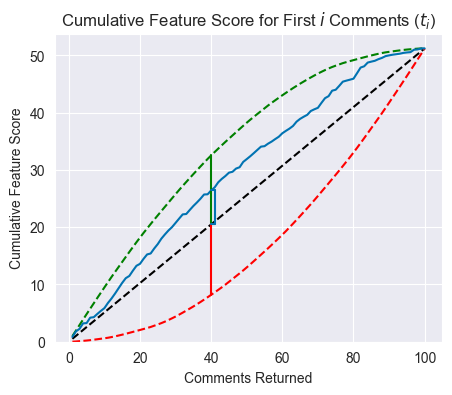

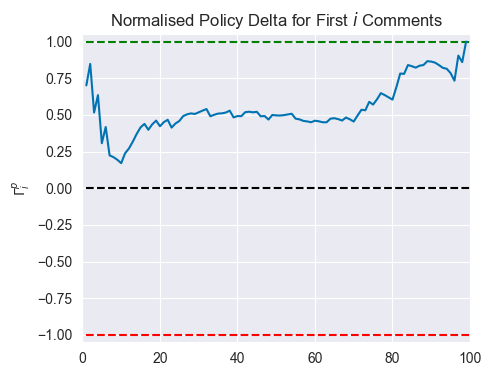

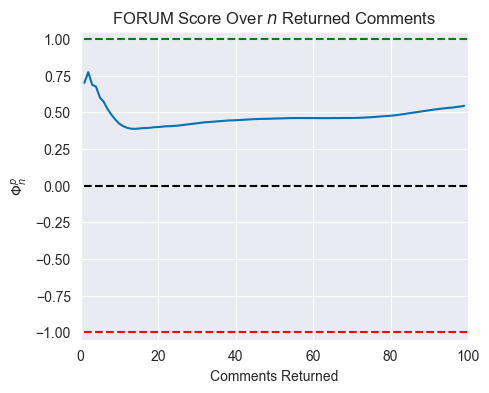

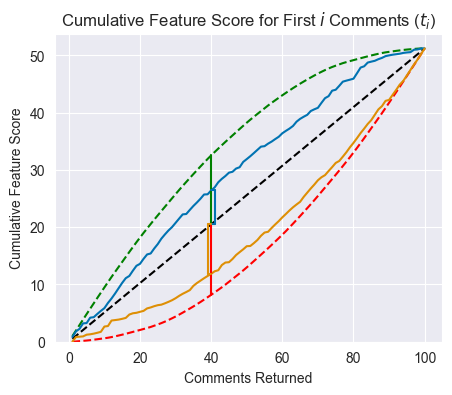

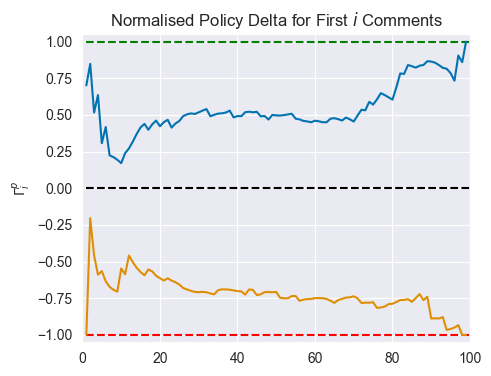

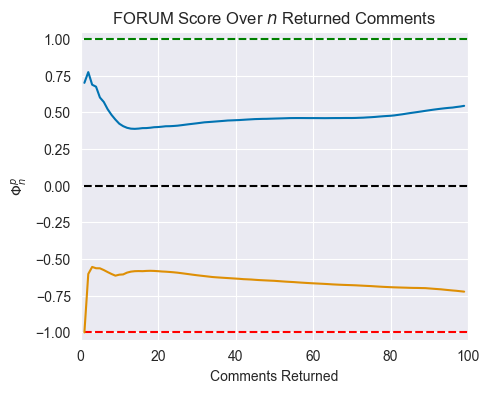

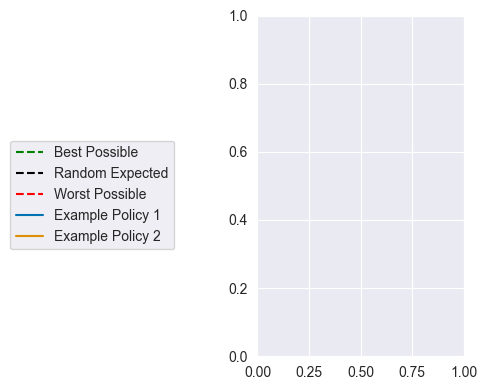

In [42]:
curve = cs_dict[1]

fig, ax = plt.subplots(1, 1, figsize=(5,4))

# plot the data
ax.plot(range(1, mm+1), cs_best, ls='--', label='Best Possible', c='g')
ax.plot(x, y, c='k', ls='--', label='Random Expected')
ax.plot(range(1, mm+1), cs_worst, ls='--', label='Worst Possible', c='r')

n = 40

ax.set_title('Cumulative Feature Score for First $i$ Comments ($t_i$)')
ax.set_ylabel('Cumulative Feature Score')
ax.set_xlabel('Comments Returned')
ax.set_ylim(0, max(50, sum(rlist)*1.05))
fig.savefig('figs/pres/feature_score_bw.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5,4))

# plot the data
ax.plot(range(1, mm+1), cs_best, ls='--', label='Best Possible', c='g')
ax.plot(x, y, c='k', ls='--', label='Random Expected')
ax.plot(range(1, mm+1), cs_worst, ls='--', label='Worst Possible', c='r')
ax.plot(range(1, mm+1), curve, label=f'Example Policy 1')

ax.set_title('Cumulative Feature Score for First $i$ Comments ($t_i$)')
ax.set_ylabel('Cumulative Feature Score')
ax.set_xlabel('Comments Returned')
ax.set_ylim(0, max(50, sum(rlist)*1.05))
fig.savefig('figs/pres/feature_score_example.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5,4))

# plot the data
ax.plot(range(1, mm+1), cs_best, ls='--', label='Best Possible', c='g')
ax.plot(x, y, c='k', ls='--', label='Random Expected')
ax.plot(range(1, mm+1), cs_worst, ls='--', label='Worst Possible', c='r')
ax.plot(range(1, mm+1), curve, label=f'Example Policy')

# add delta lines
ax.plot([n+1, n+1],  [baseline[n-1], curve[n-1]], c = sns.color_palette()[0])
ax.plot([n, n],  [baseline[n-1], cs_best[n-1]], c = 'g')
ax.plot([n, n],  [baseline[n-1], cs_worst[n-1]], c = 'r')
ax.plot([n, n+1],  [curve[n-1], curve[n-1]], c = sns.color_palette()[0])
ax.plot([n, n+1],  [baseline[n-1], baseline[n-1]], c = sns.color_palette()[0])

ax.set_title('Cumulative Feature Score for First $i$ Comments ($t_i$)')
ax.set_ylabel('Cumulative Feature Score')
ax.set_xlabel('Comments Returned')
ax.set_ylim(0, max(50, sum(rlist)*1.05))
fig.savefig('figs/pres/feature_score_example_delta.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.set_title('Normalised Policy Delta for First $i$ Comments')
ax.plot(x, [1]*size, c='g', ls='--', label='Best Possible')
ax.plot(x, [0]*size, c='k', ls='--', label='Random Expected')
ax.plot(x, [-1]*size, c='r', ls='--', label='Worst Possible')
ax.plot(range(1, mm), rat_dict[1], label=f'Policy {i}')
ax.set_ylabel('$\Gamma^p_i$')
ax.set_xlim(0, mm)
ax.set_ylim(-1.05, 1.05)
fig.savefig('figs/pres/policy_delta.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.set_title('FORUM Score Over $n$ Returned Comments')
ax.plot(x, [1]*size, c='g', ls='--', label='Best Possible')
ax.plot(x, [0]*size, c='k', ls='--', label='Random Expected')
ax.plot(x, [-1]*size, c='r', ls='--', label='Worst Possible')
ax.plot(range(1, mm), np.cumsum(rat_dict[1])/np.arange(1, mm),
            label=f'Policy {i}')
ax.set_xlabel('Comments Returned')
ax.set_ylabel('$\Phi_n^p$')
ax.set_xlim(0, mm)
ax.set_ylim(-1.05, 1.05)
fig.savefig('figs/pres/forum_score.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5,4))

# plot the data
ax.plot(range(1, mm+1), cs_best, ls='--', label='Best Possible', c='g')
ax.plot(x, y, c='k', ls='--', label='Random Expected')
ax.plot(range(1, mm+1), cs_worst, ls='--', label='Worst Possible', c='r')
ax.plot(range(1, mm+1), curve, label=f'Example Policy 1')
ax.plot(range(1, mm+1), cs_dict[3], label=f'Example Policy 2')

# add delta lines
ax.plot([n+1, n+1],  [baseline[n-1], curve[n-1]], c = sns.color_palette()[0])
ax.plot([n-1, n-1],  [baseline[n-1], cs_dict[3][n-1]], c = sns.color_palette()[1])
ax.plot([n, n],  [baseline[n-1], cs_best[n-1]], c = 'g')
ax.plot([n, n],  [baseline[n-1], cs_worst[n-1]], c = 'r')
ax.plot([n, n+1],  [curve[n-1], curve[n-1]], c = sns.color_palette()[0])
ax.plot([n, n-1],  [cs_dict[3][n-1], cs_dict[3][n-1]], c = sns.color_palette()[1])
ax.plot([n, n+1],  [baseline[n-1], baseline[n-1]], c = sns.color_palette()[0])
ax.plot([n-1, n],  [baseline[n-1], baseline[n-1]], c = sns.color_palette()[1])

ax.set_title('Cumulative Feature Score for First $i$ Comments ($t_i$)')
ax.set_ylabel('Cumulative Feature Score')
ax.set_xlabel('Comments Returned')
ax.set_ylim(0, max(50, sum(rlist)*1.05))
fig.savefig('figs/pres/feature_score_example2_delta.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.set_title('Normalised Policy Delta for First $i$ Comments')
ax.plot(x, [1]*size, c='g', ls='--', label='Best Possible')
ax.plot(x, [0]*size, c='k', ls='--', label='Random Expected')
ax.plot(x, [-1]*size, c='r', ls='--', label='Worst Possible')
ax.plot(range(1, mm), rat_dict[1], label=f'Policy {i}')
ax.plot(range(1, mm), rat_dict[3], label=f'Policy {i}')
ax.set_ylabel('$\Gamma^p_i$')
ax.set_xlim(0, mm)
ax.set_ylim(-1.05, 1.05)
fig.savefig('figs/pres/policy_delta_example2.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.set_title('FORUM Score Over $n$ Returned Comments')
ax.plot(x, [1]*size, c='g', ls='--', label='Best Possible')
ax.plot(x, [0]*size, c='k', ls='--', label='Random Expected')
ax.plot(x, [-1]*size, c='r', ls='--', label='Worst Possible')
ax.plot(range(1, mm), np.cumsum(rat_dict[1])/np.arange(1, mm),
            label=f'Example Policy 1')
ax.plot(range(1, mm), np.cumsum(rat_dict[3])/np.arange(1, mm),
            label=f'Example Policy 2')
ax.set_xlabel('Comments Returned')
ax.set_ylabel('$\Phi_n^p$')
ax.set_xlim(0, mm)
ax.set_ylim(-1.05, 1.05)
fig.savefig('figs/pres/forum_score_example2.pdf', bbox_inches='tight')
plt.show()

fig, ax2 = plt.subplots(1, 2, figsize=(5,4))
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.2, 0.5), loc='center',
           ncol=1)

ax2[0].remove()
fig.tight_layout()
fig.savefig('figs/pres/legend.pdf', bbox_inches='tight')
plt.show()